# Tinkering Notebook 3a: Model-free prediction

In Tinkering Notebook 2 we saw different ways to compute $v_\pi(s)$ given that we know the dynamics $p(s',r \mid s,a)$. In this notebook we will see how we can learn $v_\pi(s)$ in a model-free way using experience.\
在Tinkering Notebook 2中，我们看到了计算$v_\pi(s)$的不同方法，因为我们知道dynamics $p(s',r \mid s,a)$。在本笔记中，我们将看到如何使用经验，以一种无模型的方式学习$v_\pi(s)$。

**Lecture 4 - Model-free prediction**
* __Recommended Reading:__ 5.1 and 6.1-6.3

# Table of content
* ### [1. Imports](#sec1)
* ### [2. Monte-Carlo Methods](#sec2)
 * #### [2.1 Bias and variance](#sec2_1)
 * #### [2.2 Constant step size and non-stationary case](#sec2_2)
* ### [3. Monte-Carlo Prediction](#sec3)
* ### [4. Temporal Differences Prediction (TD)](#sec4)


# 1. Imports <a id="sec1">

In [1]:
import sys
package = "/Users/lmf/PycharmProjects/MSc_DS/Python/Package/gym-gridworld"
sys.path.append(package)

In [2]:
import gym
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import gym_gridworld
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# 2. Monte-Carlo Methods <a id="sec2">

In this section we will look at the example with two dice from Lecture 4.\
在这一节中，我们将看一看第四讲中有两个骰子的例子。

The main point of this section is to get a better feeling for the ideas around bias and variance, and also take a look at the difference between a constant step size or a step size that decrease over time.\
这一节的主要观点是更好地理解关于偏差（bias）和方差（variance）的想法，并看看固定步长和随时间减少的步长之间的差异。

## 2.1 Bias and variance <a id="sec2_1">

We start with by an example of throwing two dice, and we let $G$ be the sum we get from the two dices. We are interested in finding $\mathbb{E}[G]$.\
我们从掷两个骰子的例子开始，将$G$设为我们从两个骰子中得到的和。我们感兴趣的是找到$\mathbb{E}[G]$。
With hand calculations it can be shown that $\mathbb{E}[G]=7$.\
通过手工计算，可以看出$\mathbb{E}[G]=7$。

Here we instead carry out $N = 1000$ throws with the two dice and compute the average value $V$. Remember that we can compute this incrementally using (see Lecture 4)\
在这里，我们用两个骰子计算$N = 1000$次投掷，并计算平均值$V$。记住，我们可以使用下式来增量地计算（见第四讲）：
$$
V \leftarrow V + \frac{1}{n} (G - V).
$$
In the code below we also store and then plot the estimated $V$ after each throw.\
在下面的代码中，我们还存储并在每次抛出后绘制估计的$V$。

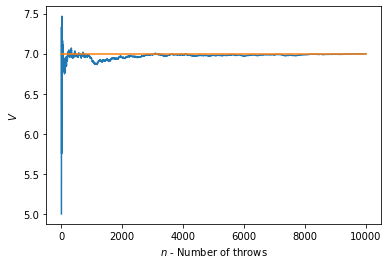

In [3]:
N = 10000 # Total number of throws
V = np.zeros(N+1) # Will be used to store the mean values

# V[0] is the initial value. (Should be zero to get true empircal mean)
# V[1] is the mean after we have thrown the dices once etc.

for n in range(1,N+1):
    dice1 = np.random.randint(1, 7) # Random between 1 and 6
    dice2 = np.random.randint(1, 7) # Random between 1 and 6
    G = dice1 + dice2
    V[n] = V[n-1] + 1/n*(G-V[n-1])
    
plt.plot(range(1,N+1), V[1:])
plt.plot([1,N], [7, 7]); # True E[G]
plt.xlabel("$n$ - Number of throws")
plt.ylabel("$V$");

**Task:** Re-run the code cell above a few times to see that the results are different every time. Note that the difference between each run is larger for small $n$ than large $n$.\
重新运行上述代码单元几次，看看每次结果都不一样。注意，每次运行的差异对于小的$n$比大的$n$更大。

**Task:** You can try to increase $N$ in the code above, to see that $V$ really converge to 7 as $n \rightarrow \infty$.\
你可以在上面的代码中尝试增加$N$，以看到$V$真正收敛到7当$n \rightarrow \infty$。

The reason that we get different results in each run is because the observations are random, so `V[n]` is random.\
我们在每次运行中得到不同结果的原因是因为观察是随机的，所以`V[n]`是随机的。

**Bias:** Tells us how much the expected value of `V[n]` differs from the true value (7). In Lecture 4 we saw that the bias in this case is 0, so `V[n]` is an unbiased estimate for all $n$. That is: If you run the code above (infinitely) many times `V[n]` will on average be 7 for all $n$.\
**偏差：**告诉我们`V[n]`的期望值与真值(7)有多大的不同。在第4讲中我们看到这种情况下的偏差是0，所以`V[n]`是所有$n$的无偏估计。也就是说：如果你无限多次运行上面的代码，那么对于所有的$n$，`V[n]`平均为7。

**Variance:** Tell us how much `V[n]` will vary around the expected value if we re-run the code many times. From running the code above many times, we see that it varies more for small $n$ than for large $n$. This is consistent with the fact that the variance is $5.83/n$ (see Lecture 4), and thus decreases as $n$ increases.\
**方差：**告诉我们，如果我们多次重新运行代码，`V[n]`将在期望值周围发生多少变化。通过多次运行上述代码，我们可以看到，相对于大的$n$，小的$n$的变化更大。这与方差为$5.83/n$的事实相一致（见第4讲），因此方差随着$n$的增加而减小。

**Consistency:** The estimate is consistent since $V \rightarrow \mathbb{E}[G] = 7$ as $n \rightarrow \infty$.\
**一致性：**估计是一致的，因为$V \rightarrow \mathbb{E}[G] = 7$当$n \rightarrow \infty$。

## 2.2 Constant step size and non-stationary case <a id="sec2_2">

The incremental update used above can be written as\
上面使用的增量更新可以写成
$$
V \leftarrow V + \alpha_n ( G - V)
$$
where $\alpha_n = 1/n$. These types of updates will come back over and over again in the course.\
其中$\alpha_n = 1/n$。这些类型的更新将回来一次又一次在课程中。

Sometimes we will use a constant $\alpha \in (0,1)$. In this section we will study constant $\alpha$ in the simple two dice example.\
有时我们会使用一个常量$\alpha \in (0,1)$。在本节中，我们将在简单的两个骰子的例子中研究常量$\alpha$。

The effect of choosing constant $\alpha$ is intuitively that we put less weight on observations that happened a long time ago. For example, with $\alpha = 1$ we get $V \leftarrow G$, i.e., we forget everything that happened before the last observation completely. (see textbook Chapter 2.5 for more discussion on this)\
选择常数$\alpha$的效果直观上是，我们对很久以前的观察结果不那么重视。例如，使用$\alpha = 1$，我们得到$V \leftarrow G$，也就是说，我们完全忘记了在最后一次观察之前发生的所有事情。(详见教科书第2.5章)

The code below is the same as in the previous section, but with a constant step size `alpha`.\
下面的代码与上一节相同，但步长为`alpha`。

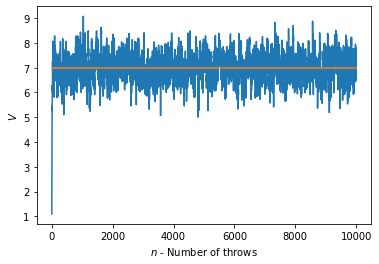

In [4]:
alpha = 0.1
N = 10000 # Total number of throws
V = np.zeros(N+1) # Will be used to store the mean values

for n in range(1,N+1):
    dice1 = np.random.randint(1, 7) # Random between 1 and 6
    dice2 = np.random.randint(1, 7) # Random between 1 and 6
    G = dice1 + dice2
    V[n] = V[n-1] + alpha*(G-V[n-1])
    
plt.plot(range(1, N+1),V[1:])
plt.plot([1,N], [7, 7]); # True E[G]
plt.xlabel("$n$ - Number of throws")
plt.ylabel("$V$");

**Task:** Vary `alpha` between 0 and 1. Try at least 0.5, 0.1 and 0.01. Also compare the result with the previous section where we used $\alpha_n = 1/n$.\
在0和1之间变化`alpha`。至少尝试0.5，0.1和0.01。还要将结果与上一节中使用的$\alpha_n = 1/n$进行比较。

**Task:** Do the same as above, but with $N=10000$ to see if the estimate seems to converge as $n \rightarrow \infty$.\
和上面做同样的操作，但是使用$N=10000$，看看当$n \rightarrow \infty$时，估计是否收敛。

From the test above you should be able to see that:\
从上面的测试你应该可以看到：
1. The estimate never converge to a fixed number. The reason for this is that $\alpha$ does not go to zero, and therefore the estimate will continue to change for each new observation even as $n \rightarrow \infty$. Another view: The larger $\alpha$ is, the more we focus on just the last couple of observations.\
估计永远不会收敛到一个固定的数字。这样的原因是$\alpha$不会趋近于零，因此即便当$n \rightarrow \infty$时，对于每个新观察值的估计也会继续变化。另一个观点是：$\alpha$越大，我们就越关注最后几个观察结果。
2. But for large $n$, the estimate will vary around the true value.\
但是对于大的$n$，估计会在真实值附近变化。
3. Smaller step size means that it takes longer to get close to the true value, but on the other hand it does not vary as much around the true value for large $n$.
较小的步长意味着它需要更长的时间才能接近真实值，但是另一方面，对于较大的$n$，它在真实值周围的变化并不大。

So, to learn fast use large $\alpha$, but to get the result as accurate as possible as $n \rightarrow \infty$ use small $\alpha$. Using the a step-size schedule such as $\alpha_n = 1/n$, combines these insights by letting $\alpha_n$ be large for small $n$ and small for large $n$.\
因此，为了快速学习，应该使用大的$\alpha$，但是为了得到当$n \rightarrow \infty$时尽可能准确的结果，使用小的$\alpha$。使用像$\alpha_n = 1/n$这样的步长时间表，通过让$\alpha_n$对于小的$n$较大，而对于大的$n$较小，结合了这些见解。

But why would we ever use a constant $\alpha$ then? Some good reasons may be:\
但是为什么我们要使用常量$\alpha$呢?一些好的理由可能是:
1. Easier to implement. In more advanced settings than just computing the mean value, it is not always obvious how a good step-size schedule $\alpha_n$ should look.\
容易实现。在比仅仅计算平均值更高级的设置中，一个好的步长时间表$\alpha_n$应该是什么样子并不总是那么明显。
2. It may not be important that the estimate converge to a fixed number (just that it gets close enough to the true value).\
估计值收敛到一个固定的值可能并不重要（只要它足够接近真实值）。
3. If the underlying probabilities may change, it is important to continue to learn! If we let $\alpha_n \rightarrow 0$, then new observations will not matter very much when $n$ is large.\
如果潜在的可能性可能改变，继续学习是很重要的！如果我们让$\alpha_n \rightarrow 0$，那么当$n$很大时，新的观察结果将不会很重要。

In the code below we first do `N_two = 1000` throws with two dice. After this one dice gets lost. So then we perform `N_one = 500` throws with only one dice (so the expected value changes from 7 to 3.5 after throw 1000).\
在下面的代码中，我们首先用两个骰子投掷`N_two = 1000`次。在此之后，一个骰子丢了。因此，我们使用一个骰子进行`N_one = 500`次掷骰（所以在投掷1000次后，期望值从7变为3.5)）。

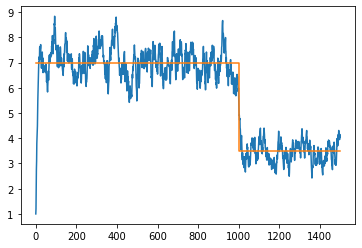

In [5]:
N_two = 1000 # Total number of throws with 2 dices
N_one = 500 # Total number of throws with 1 dice
N = N_one+N_two
V = np.zeros(N+1) # Will be used to store the mean values
alpha = 0.1

for n in range(1,N+1):
    if n<=N_two:
        dice1 = np.random.randint(1, 7) # Random between 1 and 6
        dice2 = np.random.randint(1, 7) # Random between 1 and 6
        G = dice1 + dice2
    else:
        G = np.random.randint(1,7)
    
    V[n] = V[n-1] + alpha*(G-V[n-1])
    
plt.plot(V[1:])
plt.plot([1, N_two, N_two, N], [7, 7, 3.5, 3.5])

**Task:** Change the code above to use a constant step-size `alpha` instead of `1/n`. Try different values of `alpha`. (At least 0.01, 0.1 and 0.5)\
更改上面的代码，使用常量步长`alpha`代替`1/n`。尝试不同的alpha值。(至少0.01，0.1和0.5)

It should be clear that using a constant `alpha` (where you put less weight on old observations) gives estimates that are much faster in detecting that the expected value has changed. In a real-world RL implementation, it may be important to be able to react to a change in the underlying environment (i.e. if $p(s',r \mid s,a)$ changes). It could be that we control a robot, but due to wear and tear the friction between the robot and the floor changes over time.\
显然，使用常数`alpha`（对旧的观测结果的权重较小）可以更快地检测到期望值的变化。在一个真实的RL实现中，能够对底层环境的变化做出反应是很重要的（例如，如果$p(s',r \mid s,a)$变化）。也可能是我们控制着一个机器人，但是由于磨损，机器人和地板之间的摩擦力会随着时间的推移而变化。

# 3. Monte-Carlo Prediction <a id="sec3">

We will now try to find an estimate of $v_\pi(s)$ using Monte-Carlo.\
现在我们将尝试使用Monte-Carlo来找到$v_\pi(s)$的估算值。

In Monte-Carlo prediction, we let the agent run a full episode for each state to get a trajectory [trəˈdʒektəri]\
在Monte-Carlo预测中，我们让agent对每个状态运行一个完整的episode，以得到一个轨迹（tra'jectory）
$$
S_0, R_1, S_1, R_2, S_2, R_3, ..., S_{(T-1)}, R_T, S_T
$$
where $S_T$ is a terminal state (so no future rewards are received when this state is reached).\
其中$S_T$是一个终止状态（所以当达到这个状态时，不会收到未来的reward）。

For each state we then compute\
然后，对于每种状态，我们计算
$$
G_t = R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{T-t-1} R_T.
$$
Note that if we start from the end of the episode and go backwards, we can use the recursive relationship\
请注意，如果我们从此episode的末尾开始并往回走，我们可以使用递归关系
$$
G_t = \begin{cases}
0 & \text{if } t = T \\
R_{t+1} + \gamma G_{t+1}  &\text{if } t<T
\end{cases}
$$
Below we implement the every-visit version of the MC-algorithm. Make sure that you understand the code. To change it to the first-visit version, you would also have to add code so that you only update $V(S_t)$ if $t$ is the first time you are in state $S_t$.\
下面我们将实现MC算法的每次访问版本。确保你理解了代码。要将它更改为首次访问版本，您还必须添加代码，以便仅在$t$是您第一次处于$S_t$状态时，才更新$V(S_t)$。

## __Code__: First-visit MC-algorithm

In [6]:
class MCAgent():
    
    def __init__(self, n_states, n_actions, gamma):
        self.n_actions = n_actions
        self.V = np.zeros(n_states)
        self.N = np.zeros(n_states)
        self.gamma = gamma
        
    def act(self, state):
        # Use a uniform random policy (all actions have equal probability)
        return np.random.choice(self.n_actions)
    
    def learn(self, states, rewards):
        T = len(states)
        G = 0 # G_T = 0
        # alpha = 1/self.N[states[t]]
        alpha = 0.1
        
        for t in reversed(range(T)): # From T-1 to 0
            G = rewards[t+1] + self.gamma*G # G_t: compture return recursively
            if states[t] not in states[:t]: # Remove this line to get every-visit version
                self.N[states[t]] += 1
                self.V[states[t]] += alpha * (G - self.V[states[t]]) # compute average returns incrementally

To test our implementation, we use the `GymGrid-v0` environment that was also studied in Tinkering Notebook 2. With a uniform random policy and discount $\gamma = 1$, we know that the state-value function for this environment will be\
为了测试我们的实现，我们使用了在Tinkering Notebook 2中学习过的`GymGrid-v0`环境。使用均匀随机策略和折现率$\gamma = 1$，我们知道这个环境的状态值函数将是

In [7]:
value_function = np.array([ [0.,   -14., -20., -22.],
                            [-14., -18., -20., -20.],
                            [-20., -20., -18., -14.],
                            [-22., -20., -14., 0.] ]).ravel() 
# ravel turn value_function into a flat array. To write it as a matrix use reshape.
print(value_function.reshape(4,4))

[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


To try out the MC-algorithm, we run 1000 episodes using the uniform random policy implemented in `agent.act`. After each episode we use `agent.learn` to update our current estimate of the state-value function. We also keep track off the maximum absolute error in the estimate (which we can compute since we in this case know the true value function).\
为了尝试MC算法，我们使用在`agent.act`中实现的均匀随机策略运行了1000次episode。在每一个episode之后，我们用`agent.learn`更新状态值函数的当前估计值”。我们还可以跟踪估计中的最大绝对误差（我们可以计算，因为在这种情况下我们知道真值函数）。

We also save the history of the estimated values, so that we can see how the value in different states converges.\
我们还保存了估算值的历史，以便我们可以看到不同状态下的值是如何收敛的。

In [8]:
n_episodes = 10000

env = gym.make('GridWorld-v0') # the same as in Example 3.5
agent = MCAgent(env.observation_space.n, env.action_space.n, gamma=1)

error = np.zeros(n_episodes)
values = np.zeros((n_episodes, env.observation_space.n))

for i in range(n_episodes):
    state = env.reset()
    states = []
    rewards = [0] # rewards[0] is not used in MC, so can set it to anything
    done = False
    while not done: # Run one episode with the agents policy
        states.append(state) # Add state to list of states seen
        action = agent.act(state) 
        state, reward, done, info = env.step(action)
        rewards.append(reward) # Add reward to list of rewards seen
        
    agent.learn(states, rewards) # Update value function
    values[i,:] = agent.V
    # Maximum difference between true and estimated value function:
    error[i] = np.max(np.abs(agent.V - value_function))

We first plot the maximum absolute error after each episode.\
我们首先画出每一个episode之后的最大绝对误差。

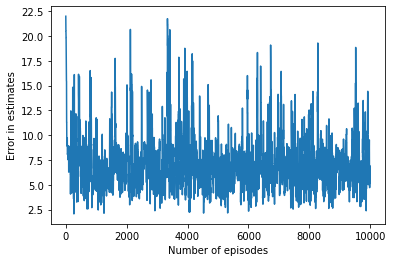

In [9]:
plt.plot(error)
plt.ylabel('Error in estimates')
plt.xlabel('Number of episodes');

And then the estimated value of state `s` after each episode. You can change `s` to look at different states.\
然后是每一个episode之后状态`s`的估计值。你可以改变`s`来查看不同的状态。

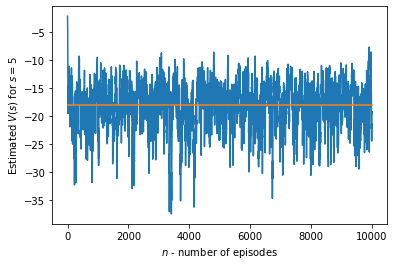

In [10]:
s = 5 
# Plot estimated value in state s
plt.plot(values[:,s])

# Plot true value in state s
plt.plot([0, n_episodes], [value_function[s], value_function[s]])

plt.xlabel('$n$ - number of episodes')
plt.ylabel("Estimated $V(s)$ for $s={}$".format({s}));

### __Tasks__: Test MC-method

1. Increase the number of episodes you use in training, and see if you get better estimates.\
增加你在训练中使用的episode数目，看看你是否能得到更好的估计。
2. Try to run the MC-method with a constant step-size. (You have to change the code in `MCAgent` and remember to execute the code cell again when you have made your changes.)\
尝试以固定的步长运行MC方法。（你必须更改`MCAgent` 中的代码，并记住在更改后再次执行代码单元格。）
 * Change `1/self.N[states[t]]` to constant `alpha`.

# 4. Temporal Differences Prediction (TD) <a id="sec4">

We now implement an agent that learn using TD. A benefit of using TD is that we do not have to wait until the end of an episode to do the updates.\
我们现在实现了一个使用TD学习的agent。使用TD的一个好处是，我们不必等到一个episode的结尾才进行更新。

## __Task__: TD-update

**Task:** Implement the TD-update in the `learn`-method of `TDAgent`. Use a constant step-size `alpha`.\
在`TDAgent`的`learn`方法中实现TD-update。使用常量步长`alpha`。

In [11]:
class TDAgent():
    
    def __init__(self, n_states, n_actions, gamma, alpha):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.V = np.zeros(n_states)
        
    def act(self, state):
        # Random
        return np.random.choice(self.n_actions)
    
    def learn(self, state, action, reward, state_next):
        self.V[state] += self.alpha * (reward + self.gamma*self.V[state_next] - self.V[state])

We will again test our agent on the `GridWorld-v0` with environment with a uniform policy and discount $\gamma = 1$, so the true value function is\
我们将再次在`GridWorld-v0`环境中测试我们的agent，使用均匀的策略和折现率$\gamma = 1$，所以真正的值函数是

In [12]:
value_function = np.array([ [0.,   -14., -20., -22.],
                            [-14., -18., -20., -20.],
                            [-20., -20., -18., -14.],
                            [-22., -20., -14., 0.] ]).ravel() 
# ravel turn value_function into a flat array. To write it as a matrix use reshape.
print(value_function.reshape(4,4))

[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


The code below runs 1000 episodes. Note that we now have moved the `learn` inside the `while`-loop, since we do not have to wait for the episode to end. This also makes it possible to use the TD-method in continuing environments (that never terminates).\
下面的代码运行1000次episode。注意，我们现在已经将`learn`移动到了`while`循环中，因为我们不必等待episode结束。这也使得在持续的环境（永不终止的环境）中使用TD方法成为可能。

In [13]:
env = gym.make('GridWorld-v0') # the same as in Example 3.5

n_episodes = 10000
s = 5 # The state we save the history for
error = np.zeros(n_episodes)
values = np.zeros((n_episodes, env.observation_space.n))

agent = TDAgent(env.observation_space.n, env.action_space.n, alpha = 0.01, gamma = 1)

for i in range(n_episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state_next, reward, done, info = env.step(action)
        agent.learn(state, action, reward, state_next)
        state = state_next
        
    error[i] = np.max(np.abs(agent.V - value_function))
    values[i, :] = agent.V

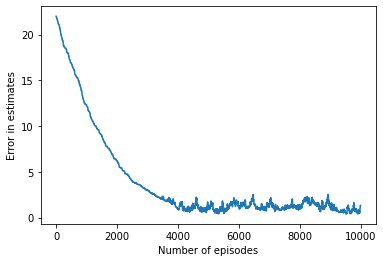

In [14]:
plt.plot(error)
plt.ylabel('Error in estimates')
plt.xlabel('Number of episodes');

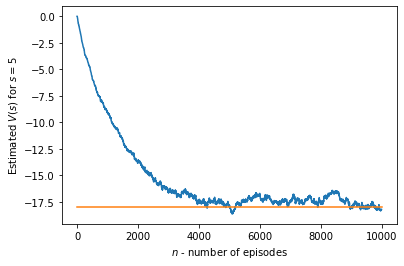

In [15]:
s = 5
plt.plot(values[:, s])
plt.plot([0, n_episodes], [value_function[s], value_function[s]])
plt.xlabel('$n$ - number of episodes')
plt.ylabel("Estimated $V(s)$ for $s={}$".format({s}));

### __Task__: Test TD
1. Try different step sizes `alpha`, and try to use more episodes.\
尝试不同的步长`alpha`，并尝试使用更多的episode。